In [3]:
import numpy as np
import math
from scipy.fftpack import fft, ifft,fftfreq
import math
from scipy.signal.windows import tukey
import sys
sys.path.append("/home/ljq/code/MOO")
from utils.Lumi_redshift import *
GM_sun = 1.3271244*1e20 #   这个式子等于  G * M_sun
c =2.9979246*1e8
M_sun =1.9884099*1e30
G = 6.6743*1e-11
pc= 3.0856776*1e16
pi = np.pi
Mpc = (10**6) * pc
def inner_prod(sig1_f,sig2_f,PSD,delta_f):
    """
    Inputs:
    sig1_f, sig2_f are continuous time fourier transforms with dimensions of seconds.
    PSD (power spectral density) defined in the function below. 
    delta_f : spacing of fourier frequencies
    
    outputs: Standard inner product, dimensionless.
    """
    return (4*delta_f)*np.real(sum(sig1_f*np.conjugate(sig2_f)/PSD))

def PSD_Lisa(f):
    
    """
    From https://arxiv.org/pdf/1803.01944.pdf. 
    """

    L = 2.5*10**9   # Length of LISA arm
    f0 = c/(2*np.pi*L)   
    
    Poms = ((1.5*10**-11)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (3*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
    Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \
                                            + np.tanh(1680*(0.00215 - f)))   # Confusion noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    PSD = ((10/(3*L*L))*(Poms + (4*Pacc)/(np.power(2*np.pi*f,4)))*(1 + 0.6*(f/f0)*(f/f0)) + Sc) # PSD
        
    # Handling the zeroth frequency bin
    
    where_are_NaNs = np.isnan(PSD) 
    PSD[where_are_NaNs] = 1e100    # at f = 0, PSD is infinite. Approximate infinity and burn my 
                                   # mathematics degree to the ground. 
    
    return PSD
def PSD_Lisa_no_Response(f):
    
    """
    From https://arxiv.org/pdf/1803.01944.pdf. 
    """

    L = 2.5*10**9   # Length of LISA arm
    f0 = c/(2*np.pi*L)   
    
    Poms = ((1.5*10**-11)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (3*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
    Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \
                                            + np.tanh(1680*(0.00215 - f)))   # Confusion noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    PSD = ((1/(L*L))*(Poms + (4*Pacc)/(np.power(2*np.pi*f,4))) + Sc) # PSD
        
    # Handling the zeroth frequency bin
    
    where_are_NaNs = np.isnan(PSD) 
    PSD[where_are_NaNs] = 1e100    # at f = 0, PSD is infinite. Approximate infinity and burn my 
                                   # mathematics degree to the ground. 
    
    return PSD
def PSD_Tianqin(f):
    
    """
    From https://arxiv.org/pdf/1803.01944.pdf. 
    """

    L = 1.7*10**8   # Length of LISA arm
    f0 = c/(2*np.pi*L)      
    
    Poms = ((1.0*10**-12)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (1*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
    Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \
                                            + np.tanh(1680*(0.00215 - f)))   # Confusion noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    PSD = ((10/(3*L*L))*(Poms + (4*Pacc)/(np.power(2*np.pi*f,4)))*(1 + 0.6*(f/f0)*(f/f0)) + Sc) # PSD
        
    # Handling the zeroth frequency bin
    
    where_are_NaNs = np.isnan(PSD) 
    PSD[where_are_NaNs] = 1e100    # at f = 0, PSD is infinite. Approximate infinity and burn my 
                                   # mathematics degree to the ground. 
    
    return PSD
def Index(alpha,beta,f,f_0):
    return alpha*np.power(f/f_0,beta)
def inner_prod_for_Index(sig1_f,sig2_f,Index,df,f_1,f_2,freq):
    freq_seq=[]
    for i in np.arange(len(sig1_f)):
        if freq[i]>=f_1 and freq[i]<=f_2:
            freq_seq=np.append(freq_seq,i)
            
    fseq=[int(x) for x in freq_seq]    
    
    return (4*df) *np.real(sum(sig1_f[fseq]*np.conjugate(sig2_f[fseq])/Index[fseq]**2))


In [4]:
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap, 
                               get_mismatch, 
                               get_fundamental_frequencies, 
                               get_separatrix, 
                               get_mu_at_t, 
                               get_p_at_t, 
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase
use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

# set omp threads one of two ways
num_threads = 4

# this is the general way to set it for all computations
# from few.utils.utility import omp_set_num_threads
# omp_set_num_threads(num_threads)

few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
    num_threads=num_threads,  # 2nd way for specific classes
)

In [5]:
#q=1e-4#mass ratio
# parameters
M = 5e5
mu=10
p0 = 12.0
e0 = 0.4
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle
dt = 10
dist=DL(4)
T=0.5
h = few(M, mu, p0, e0, theta, phi,dist=dist, dt=dt, T=T)  
# h=h.get()
print(len(h))
wave1 = np.array(h)
freq = np.array(np.arange(len(h))/dt/ len(h))


# 生成一个窗口并逐点相乘
N = wave1.size
window = tukey(N, alpha=1/8)   # 0.125 较常用
wave1 = wave1 * window


waveform1 = fft(wave1)
waveform2 = np.column_stack((waveform1, freq))
temp=waveform2.real*waveform2.real+waveform2.imag*waveform2.imag
waveform = np.sqrt(temp)

1577908


In [6]:
import sys
sys.path.append("/home/ljq/code/MOO/Workspace")
from Index.TianQin import TianQin
tq=TianQin()
PSD=tq.Sn

In [11]:
#确定Tianqin方案的指标
f_1=3e-3
f_2=7e-3
f1=np.array([f_1])
f2=np.array([f_2])
dy=float(PSD(f1)/PSD(f2))
betaTianqin=1/2*math.log(dy,10)/math.log(f1/f2,10)
print(betaTianqin)
SNR_IndexforTianqin=100000
alphaTianqin=2.2e-19
indexTianqin=Index(alphaTianqin,betaTianqin,freq,1e-3)

df=freq[1]-freq[0]
alpha=1.74e-19
beta=-2.10
index=Index(alpha,beta,freq,1e-3)
print(len(waveform1))
SNR_IndexforTianqin=inner_prod_for_Index(waveform1,waveform1,indexTianqin,df,f_1,f_2,freq)
SNR_Index=inner_prod_for_Index(waveform1,waveform1,np.sqrt(PSD(freq)),df,f_1,f_2,freq)

print(SNR_IndexforTianqin,SNR_Index)
while(np.sqrt(SNR_IndexforTianqin)>np.sqrt(SNR_Index)):
    alphaTianqin+=0.01*1e-19
    indexTianqin=Index(alphaTianqin,betaTianqin,freq,1e-3)
    SNR_IndexforTianqin=inner_prod_for_Index(waveform1,waveform1,indexTianqin,df,f_1,f_2,freq)
    print("alpha:",alphaTianqin)
    print("SNR_IndexforTianqin:",np.sqrt(SNR_IndexforTianqin))
    print("SNR_Index:",np.sqrt(SNR_Index))
print(np.sqrt(SNR_IndexforTianqin))

-1.6290353086951224
1577908


/home/ljq/miniconda3/envs/few_env/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in power
/home/ljq/code/MOO/Workspace/Index/TianQin.py:22: RuntimeWarning: divide by zero encountered in true_divide
  P_acc = (1e-15)**2 * (1. + (1e-4/f)**2)  # TianQin acceleration noise (approx)


6.402323521634611e-05 1.3205030413733167e-05
alpha: 2.2099999999999997e-19
SNR_IndexforTianqin: 0.007965246403768448
SNR_Index: 0.003633872646878694
alpha: 2.2199999999999996e-19
SNR_IndexforTianqin: 0.007929366915463181
SNR_Index: 0.003633872646878694
alpha: 2.2299999999999994e-19
SNR_IndexforTianqin: 0.007893809216290681
SNR_Index: 0.003633872646878694
alpha: 2.2399999999999993e-19
SNR_IndexforTianqin: 0.007858568996575119
SNR_Index: 0.003633872646878694
alpha: 2.249999999999999e-19
SNR_IndexforTianqin: 0.00782364202325703
SNR_Index: 0.003633872646878694
alpha: 2.259999999999999e-19
SNR_IndexforTianqin: 0.007789024138198366
SNR_Index: 0.003633872646878694
alpha: 2.269999999999999e-19
SNR_IndexforTianqin: 0.007754711256532279
SNR_Index: 0.003633872646878694
alpha: 2.2799999999999987e-19
SNR_IndexforTianqin: 0.007720699365056277
SNR_Index: 0.003633872646878694
alpha: 2.2899999999999985e-19
SNR_IndexforTianqin: 0.007686984520667356
SNR_Index: 0.003633872646878694
alpha: 2.29999999999999

/home/ljq/miniconda3/envs/few_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


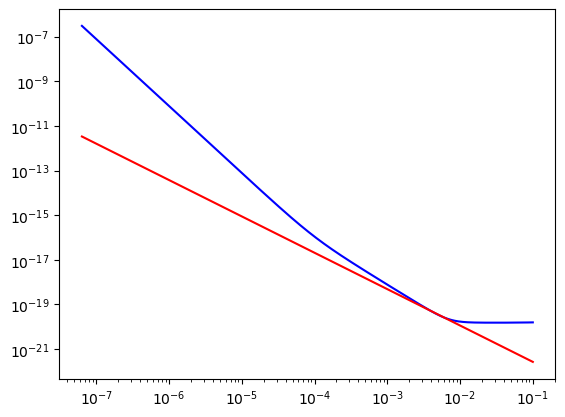

In [ ]:
from matplotlib import pyplot as plt
from Index.TianQin import PlotSensitivityCurve

plt.loglog(freq,np.sqrt(PSD(freq)),'b',label='Tianqin Sensitivity Curve')
plt.loglog(freq,alphaTianqin*np.power(freq/1e-3,betaTianqin),'r',label='Index for Tianqin')